In [2]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from matplotlib.dates import MonthLocator, DateFormatter

In [3]:
S_0 = 1360 # Solar constant [W/m2]
d_n = np.array(range(365)) # days
th_d = 2*np.pi*d_n/365

In [4]:
# Fourier series coefficients 
a_n = np.array([1.000110, 0.034221, 0.000719])
b_n = np.array([0, 0.001280, 0.000077])
n = len(a_n)

In [5]:
complex_terms = a_n + 1j * b_n
result = np.sum(complex_terms * np.exp(-1j * np.outer(th_d, np.arange(n))), axis=1)
d_ratio_sq = np.real(result) # (mean distance Earth-Sun / actual distance on that day)^2 --> depends on days

In [6]:
# Fourier series coefficients 
a_n = np.array([0.006918, -0.399912, -0.006758, -0.002697])
b_n = np.array([0, 0.070257, 0.000907, 0.001480])
n = len(a_n)

In [7]:
complex_terms = a_n + 1j * b_n
result = np.sum(complex_terms * np.exp(-1j * np.outer(th_d, np.arange(n))), axis=1)
delta = np.real(result) # declination angle --> depends on days

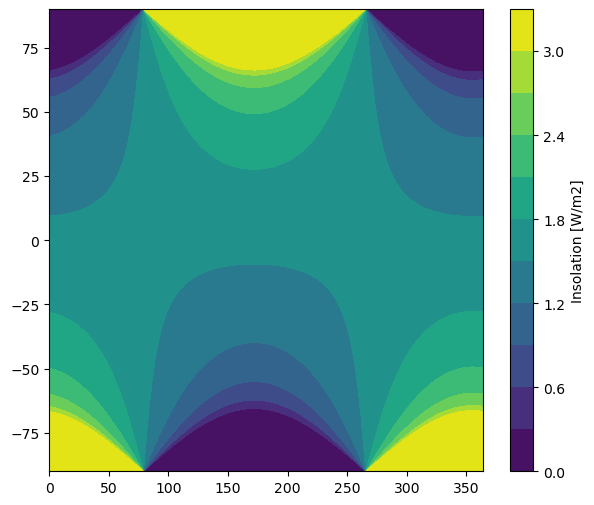

In [22]:
phi_lat = np.arange(-90, 90.01, 0.01) # latitude in degrees
tan_product = -np.outer(np.tan(np.radians(phi_lat)), np.tan(delta)) # depends on lat

tan_product = np.clip(tan_product, -1, 1) # some values are out of cosine range

h = np.arccos(tan_product) # hour angle at sunrise and sunset --> depends on lat and days

plt.figure(figsize=(7, 6))
contour = plt.contourf(d_n, phi_lat, h, cmap='viridis', levels=10)
plt.colorbar(contour, label='Insolation [W/m2]')
plt.show()

In [17]:
Q_par1 = h * np.outer(np.sin(np.radians(phi_lat)), np.sin(delta) * d_ratio_sq) 
Q_par2 = np.sin(h) * np.outer(np.cos(np.radians(phi_lat)), np.cos(delta) * d_ratio_sq) 
Q = S_0 * (Q_par1 + Q_par2) / np.pi # TOA daily average insolation

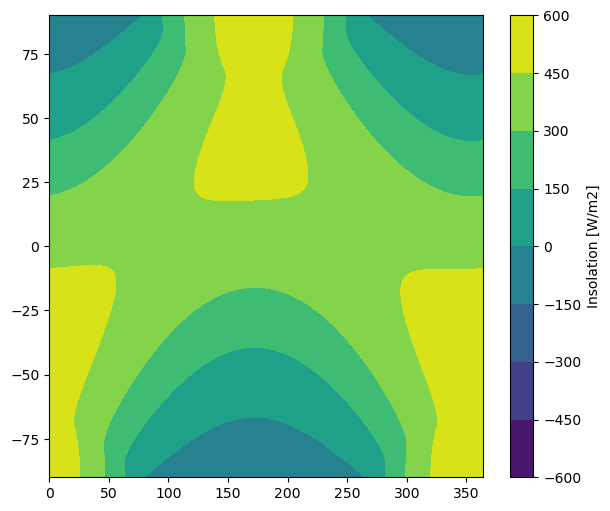

In [18]:
plt.figure(figsize=(7, 6))
contour = plt.contourf(d_n, phi_lat, Q, cmap='viridis', levels=10)
plt.colorbar(contour, label='Insolation [W/m2]')
plt.show()

In [19]:
start_date = datetime.strptime('2024-01-01', '%Y-%m-%d') 
dates = [start_date + timedelta(days=int(day)) for day in d_n]

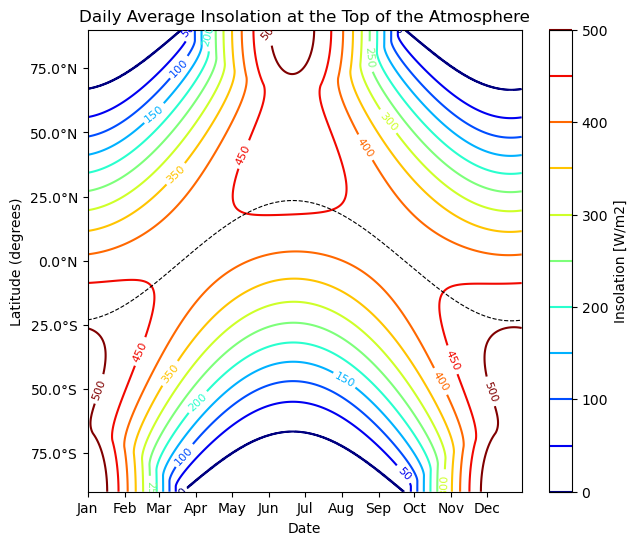

In [20]:
plt.figure(figsize=(7, 6))
contour = plt.contour(dates, phi_lat, Q, cmap='jet', levels=np.linspace(0, 500, 11))
plt.clabel(contour, inline=True, fontsize=8, fmt='%d')

plt.plot(dates, np.degrees(delta), 'k--', linewidth=0.8)

# Customize the x-axis ticks to show only month names
plt.gca().xaxis.set_major_locator(MonthLocator())
plt.gca().xaxis.set_major_formatter(DateFormatter('%b'))

# Customize the y-axis ticks to show #N for positive values and #S for negative values
plt.gca().yaxis.set_major_formatter(lambda value, tick_number: f'{abs(value)}°{"N" if value >= 0 else "S"}')

plt.colorbar(contour, label='Insolation [W/m2]')
plt.xlabel('Date')
plt.ylabel('Latitude (degrees)')
plt.title('Daily Average Insolation at the Top of the Atmosphere')
plt.show()